<a href="https://colab.research.google.com/github/Je73hwg/intelligent-traffic-signal-emergency-priority/blob/main/Intelligent_Traffic_Signal_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 1 — Imports & Global Configuration

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional
from enum import Enum

# ── Reproducibility ──────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# ── Intersection Configuration ────────────────────────────────
ROADS = ['North', 'South', 'East', 'West']
NORMAL_GREEN_TIME    = 30    # Seconds of green per road in normal rotation
YELLOW_TIME          = 5     # Amber transition between phases (seconds)
AMBULANCE_GREEN_TIME = 60    # Extended green time for ambulance road
SIM_DURATION         = 1800  # Total simulation time (30 minutes)
AMBULANCE_PROB       = 0.05  # 5% chance a vehicle batch includes an ambulance
VEHICLES_PER_CYCLE_MEAN = 8  # Mean vehicles arriving per phase window
VEHICLES_PER_CYCLE_STD  = 3  # Standard deviation of vehicle arrivals

# ── Visual Theme ─────────────────────────────────────────────
plt.rcParams.update({
    'figure.facecolor': '#0d1117',
    'axes.facecolor':   '#161b22',
    'axes.edgecolor':   '#30363d',
    'axes.labelcolor':  '#e6edf3',
    'xtick.color':      '#8b949e',
    'ytick.color':      '#8b949e',
    'text.color':       '#e6edf3',
    'grid.color':       '#21262d',
    'grid.linestyle':   '--',
    'legend.facecolor': '#161b22',
    'legend.edgecolor': '#30363d',
})

# Colour palette
ROAD_COLORS   = {'North':'#58a6ff','South':'#3fb950','East':'#f78166','West':'#d2a8ff'}
RED_COLOR     = '#ff6b6b'
GREEN_COLOR   = '#51cf66'
YELLOW_COLOR  = '#ffd43b'
AMBULANCE_CLR = '#ff4757'

print('Configuration loaded.')
print(f'  Roads            : {ROADS}')
print(f'  Normal green     : {NORMAL_GREEN_TIME}s')
print(f'  Ambulance green  : {AMBULANCE_GREEN_TIME}s')
print(f'  Sim duration     : {SIM_DURATION}s ({SIM_DURATION//60} min)')
print(f'  Ambulance prob   : {AMBULANCE_PROB*100:.0f}% per vehicle batch')


Configuration loaded.
  Roads            : ['North', 'South', 'East', 'West']
  Normal green     : 30s
  Ambulance green  : 60s
  Sim duration     : 1800s (30 min)
  Ambulance prob   : 5% per vehicle batch


In [ ]:
# CELL 2 — Data Structures

class SignalState(Enum):
    """Possible traffic light states for a single road arm."""
    RED    = 'RED'
    GREEN  = 'GREEN'
    YELLOW = 'YELLOW'


@dataclass
class Vehicle:
    """
    Represents a single vehicle at the intersection.
    Tracks arrival time, road, and whether it is an ambulance.
    """
    vehicle_id:   int
    road:         str            # Which road the vehicle arrived on
    arrival_time: float          # Simulation clock when vehicle arrived
    is_ambulance: bool = False   # True for emergency vehicles
    cleared_time: Optional[float] = None  # Set when vehicle passes junction

    @property
    def wait_time(self) -> float:
        """Total seconds spent waiting before clearing the intersection."""
        if self.cleared_time is None:
            return 0.0
        return max(0.0, self.cleared_time - self.arrival_time)


@dataclass
class PhaseRecord:
    """Records metadata for one complete green phase."""
    phase_id:         int
    active_road:      str    # The road that had GREEN
    start_time:       float  # Simulation clock at phase start
    end_time:         float  # Simulation clock at phase end
    green_duration:   float  # Actual green seconds given
    is_emergency:     bool = False  # True if triggered by ambulance
    vehicles_cleared: int  = 0     # How many vehicles passed


@dataclass
class RoadQueue:
    """Manages the queue of vehicles waiting on a single road arm."""
    road_name:     str
    queue:         List[Vehicle] = field(default_factory=list)
    signal:        SignalState   = SignalState.RED
    has_ambulance: bool          = False  # Detection flag

    def add_vehicle(self, vehicle: Vehicle):
        """Enqueue a vehicle; update ambulance flag if applicable."""
        self.queue.append(vehicle)
        if vehicle.is_ambulance:
            self.has_ambulance = True  # Raise detection flag

    def clear_vehicles(self, clock: float,
                        max_vehicles: int = None) -> List[Vehicle]:
        """
        Clear up to `max_vehicles` from this road's queue.
        Ambulances are prioritised (moved to front).
        Timestamps each cleared vehicle with cleared_time.

        Args:
            clock        : current simulation time (green phase start)
            max_vehicles : capacity limit (None = clear all)

        Returns:
            List of vehicles that successfully cleared the junction.
        """
        # Ambulances go first; tie-break by arrival order
        self.queue.sort(key=lambda v: (not v.is_ambulance, v.arrival_time))

        n = len(self.queue) if max_vehicles is None else min(max_vehicles, len(self.queue))
        cleared = []
        for i in range(n):
            v = self.queue[i]
            v.cleared_time = clock + (i * 2.5)  # 2.5s gap between vehicles
            cleared.append(v)

        self.queue = self.queue[n:]  # Remaining vehicles stay queued
        # Update ambulance flag (in case ambulance is still waiting)
        self.has_ambulance = any(v.is_ambulance for v in self.queue)
        return cleared

    @property
    def queue_length(self) -> int:
        return len(self.queue)


print('Data structures defined: SignalState, Vehicle, PhaseRecord, RoadQueue')


Data structures defined: SignalState, Vehicle, PhaseRecord, RoadQueue


In [ ]:
# CELL 3 — Signal Controller
# Rule-based finite-state machine controlling all 4 road signals.


class SignalController:
    """
    Rule-based Traffic Signal Controller for a 4-way intersection.

    NORMAL MODE  : cycles North → South → East → West
                   each with NORMAL_GREEN_TIME seconds of green.

    EMERGENCY MODE: immediately overrides all signals,
                   gives GREEN to ambulance road for AMBULANCE_GREEN_TIME,
                   then resumes normal rotation.
    """

    def __init__(self, roads: List[str], normal_green: int,
                 ambulance_green: int, yellow_time: int):
        self.roads           = roads
        self.normal_green    = normal_green
        self.ambulance_green = ambulance_green
        self.yellow_time     = yellow_time
        # One RoadQueue per arm of the intersection
        self.road_queues: Dict[str, RoadQueue] = {
            r: RoadQueue(road_name=r) for r in roads
        }
        self._phase_index   = 0  # Round-robin rotation pointer
        self._phase_log: List[PhaseRecord] = []
        self._phase_counter = 0

    # ── Internal signal helpers ───────────────────────────────

    def _set_all_red(self):
        """Force every road to RED — safety step before any phase change."""
        for rq in self.road_queues.values():
            rq.signal = SignalState.RED

    def _set_green(self, road: str):
        """Give one road GREEN; all others stay/become RED."""
        self._set_all_red()
        self.road_queues[road].signal = SignalState.GREEN

    def _set_yellow(self, road: str):
        """Transition the active-green road to YELLOW before switching."""
        self.road_queues[road].signal = SignalState.YELLOW

    def _detect_ambulance(self) -> Optional[str]:
        """
        Scan all road queues for an ambulance detection flag.
        Returns the road name of the first ambulance found, or None.

        In a real system this reads from sensors/GPS instead of flags.
        """
        for road in self.roads:
            if self.road_queues[road].has_ambulance:
                return road
        return None

    # ── Phase execution ───────────────────────────────────────

    def run_normal_phase(self, clock: float) -> Tuple[PhaseRecord, float]:
        """
        Execute the next normal green phase in rotation order.

        Sequence:
          1. Select next road (round-robin)
          2. Set GREEN for that road
          3. Estimate vehicles that can pass in NORMAL_GREEN_TIME
          4. Advance clock by green + yellow duration
          5. Log the phase

        Returns: (PhaseRecord, updated_clock)
        """
        road = self.roads[self._phase_index % len(self.roads)]
        self._phase_index += 1
        phase_start = clock

        self._set_green(road)

        # ~1 vehicle passes every 2.5 seconds in green phase
        max_passable = max(1, int(self.normal_green / 2.5))
        cleared = self.road_queues[road].clear_vehicles(clock, max_passable)

        clock += self.normal_green
        self._set_yellow(road)
        clock += self.yellow_time

        self._phase_counter += 1
        record = PhaseRecord(
            phase_id=self._phase_counter, active_road=road,
            start_time=phase_start, end_time=clock,
            green_duration=self.normal_green, is_emergency=False,
            vehicles_cleared=len(cleared)
        )
        self._phase_log.append(record)
        return record, clock

    def run_emergency_phase(self, clock: float,
                             ambulance_road: str) -> Tuple[PhaseRecord, float]:
        """
        EMERGENCY OVERRIDE — immediately prioritise the ambulance road.

        Sequence:
          1. Force ALL roads to RED (2s all-red clearance interval)
          2. Give GREEN to ambulance road
          3. Clear ALL vehicles on ambulance road (unlimited capacity)
          4. Run extended AMBULANCE_GREEN_TIME
          5. YELLOW transition, then log phase

        Returns: (PhaseRecord, updated_clock)
        """
        phase_start = clock

        # Step 1: All-RED safety interval
        self._set_all_red()
        clock += 2  # 2 second all-red clearance

        # Step 2: Ambulance road gets GREEN
        self._set_green(ambulance_road)

        # Step 3 & 4: Clear entire queue + run extended green time
        cleared = self.road_queues[ambulance_road].clear_vehicles(clock)
        clock  += self.ambulance_green

        # Step 5: Yellow transition
        self._set_yellow(ambulance_road)
        clock += self.yellow_time

        self._phase_counter += 1
        record = PhaseRecord(
            phase_id=self._phase_counter, active_road=ambulance_road,
            start_time=phase_start, end_time=clock,
            green_duration=self.ambulance_green, is_emergency=True,
            vehicles_cleared=len(cleared)
        )
        self._phase_log.append(record)
        return record, clock

    # ── Public step ───────────────────────────────────────────

    def step(self, clock: float) -> Tuple[PhaseRecord, float]:
        """
        Execute the next signal phase.
        Automatically chooses EMERGENCY or NORMAL based on detection.
        """
        ambulance_road = self._detect_ambulance()
        if ambulance_road is not None:
            return self.run_emergency_phase(clock, ambulance_road)
        return self.run_normal_phase(clock)

    def current_signals(self) -> Dict[str, str]:
        """Return current signal state for all roads."""
        return {r: self.road_queues[r].signal.value for r in self.roads}

    def get_phase_log(self) -> pd.DataFrame:
        """Return the complete phase history as a DataFrame."""
        return pd.DataFrame([{
            'phase_id': p.phase_id, 'active_road': p.active_road,
            'start_time': p.start_time, 'end_time': p.end_time,
            'green_duration': p.green_duration, 'is_emergency': p.is_emergency,
            'vehicles_cleared': p.vehicles_cleared,
        } for p in self._phase_log])


print('SignalController defined.')
print('  Methods: step(), run_normal_phase(), run_emergency_phase(),')
print('           current_signals(), get_phase_log()')


SignalController defined.
  Methods: step(), run_normal_phase(), run_emergency_phase(),
           current_signals(), get_phase_log()


In [ ]:
# CELL 4 — Traffic Generator & Ambulance Detector


class TrafficGenerator:
    """
    Generates synthetic vehicle arrival events for each road arm.

    Vehicle counts per phase follow a truncated normal distribution,
    mimicking real-world Poisson-like traffic arrival patterns.
    Each vehicle is independently assigned the ambulance flag with
    probability `ambulance_prob`.
    """

    def __init__(self, mean_vehicles: float, std_vehicles: float,
                 ambulance_prob: float = 0.0):
        """
        Args:
            mean_vehicles  : average vehicles arriving per green cycle
            std_vehicles   : std dev of vehicle count (normal dist)
            ambulance_prob : probability any given vehicle is an ambulance
                             (0.0 for the normal scenario)
        """
        self.mean         = mean_vehicles
        self.std          = std_vehicles
        self.amb_prob     = ambulance_prob
        self._vehicle_id  = 0  # Monotonically increasing global ID

    def _next_id(self) -> int:
        self._vehicle_id += 1
        return self._vehicle_id

    def generate_arrivals(self, road: str, clock: float,
                           window: float) -> List[Vehicle]:
        """
        Generate vehicles arriving on `road` in a `window`-second interval.

        Args:
            road   : which road arm ('North', 'South', 'East', 'West')
            clock  : simulation time at the start of this window
            window : duration of the arrival window (seconds)

        Returns:
            List of Vehicle objects with random arrival timestamps.
        """
        count = max(0, int(np.random.normal(self.mean, self.std)))
        vehicles = []
        for _ in range(count):
            arrival      = clock + random.uniform(0, window)  # Random within window
            is_ambulance = (random.random() < self.amb_prob)  # Stochastic flag
            vehicles.append(Vehicle(
                vehicle_id   = self._next_id(),
                road         = road,
                arrival_time = arrival,
                is_ambulance = is_ambulance
            ))
        return vehicles


class AmbulanceDetector:
    """
    Simulates hardware ambulance detection at the intersection.

    Real-world equivalents:
      - IR emitters on ambulances (Opticom® system)
      - Acoustic siren frequency detection (>400 Hz threshold)
      - GPS beacon + V2X (Vehicle-to-Infrastructure) signals
      - Camera-based emergency light pattern recognition

    Here it reads the `has_ambulance` flag set by TrafficGenerator.
    """

    @staticmethod
    def scan(road_queues: Dict[str, RoadQueue]) -> Optional[str]:
        """
        Scan all road queues for an emergency vehicle.

        Returns the road name where an ambulance is detected,
        or None if no emergency is currently active.
        """
        for road, rq in road_queues.items():
            if rq.has_ambulance:
                return road
        return None


print('TrafficGenerator and AmbulanceDetector defined.')


TrafficGenerator and AmbulanceDetector defined.


In [ ]:
# CELL 5 — Simulation Engine
# Main loop: generate vehicles → execute phases → collect results


def run_simulation(scenario: str,
                   duration: int      = SIM_DURATION,
                   normal_green: int  = NORMAL_GREEN_TIME,
                   amb_green: int     = AMBULANCE_GREEN_TIME,
                   yellow: int        = YELLOW_TIME,
                   amb_prob: float    = 0.0,
                   verbose: bool      = False) -> dict:
    """
    Run a full traffic intersection simulation.

    Args:
        scenario     : label string ('normal' or 'emergency')
        duration     : total simulation time in seconds
        normal_green : green phase duration in normal rotation (s)
        amb_green    : green phase duration for ambulance override (s)
        yellow       : amber transition duration (s)
        amb_prob     : probability of ambulance per vehicle batch
                       (0 for normal scenario; AMBULANCE_PROB for emergency)
        verbose      : print phase-by-phase debug output

    Returns:
        dict with:
          'all_vehicles'      — every Vehicle object created
          'cleared_vehicles'  — vehicles that successfully passed
          'phase_log'         — DataFrame of all PhaseRecord entries
          'wait_times_normal' — wait times for non-ambulance vehicles
          'wait_times_amb'    — wait times for ambulance vehicles
          'controller'        — SignalController instance (for inspection)
          'sim_duration'      — final clock value (seconds)
          'total_phases'      — total phases executed
    """
    controller = SignalController(
        roads=ROADS, normal_green=normal_green,
        ambulance_green=amb_green, yellow_time=yellow
    )
    generator = TrafficGenerator(
        mean_vehicles=VEHICLES_PER_CYCLE_MEAN,
        std_vehicles=VEHICLES_PER_CYCLE_STD,
        ambulance_prob=amb_prob
    )

    all_vehicles: List[Vehicle] = []
    clock       = 0.0
    phase_count = 0

    # ── Main simulation loop ───────────────────────────────────
    while clock < duration:

        # 1. Generate new vehicle arrivals for each road
        #    Vehicles arrive during the upcoming phase window
        arrival_window = normal_green + yellow
        for road in ROADS:
            new_vehicles = generator.generate_arrivals(
                road=road, clock=clock, window=arrival_window
            )
            for v in new_vehicles:
                controller.road_queues[road].add_vehicle(v)
                all_vehicles.append(v)

        # 2. Execute next phase (emergency override OR normal rotation)
        phase_record, clock = controller.step(clock)
        phase_count += 1

        if verbose:
            tag = '🚨 EMERGENCY' if phase_record.is_emergency else '🟢 Normal  '
            print(f'  Phase {phase_record.phase_id:3d} {tag} | '
                  f'Road: {phase_record.active_road:5s} | '
                  f'Clock: {clock:6.0f}s | '
                  f'Cleared: {phase_record.vehicles_cleared:3d}')

    # 3. Collect results — only vehicles that actually cleared
    cleared_vehicles = [v for v in all_vehicles if v.cleared_time is not None]

    return {
        'scenario':          scenario,
        'all_vehicles':      all_vehicles,
        'cleared_vehicles':  cleared_vehicles,
        'phase_log':         controller.get_phase_log(),
        'wait_times_normal': [v.wait_time for v in cleared_vehicles if not v.is_ambulance],
        'wait_times_amb':    [v.wait_time for v in cleared_vehicles if v.is_ambulance],
        'controller':        controller,
        'sim_duration':      clock,
        'total_phases':      phase_count,
    }


print('Simulation engine defined: run_simulation()')


Simulation engine defined: run_simulation()


In [ ]:
# CELL 6 — Metrics Engine
# Compute performance statistics and generate comparison tables.

def compute_metrics(sim_result: dict) -> dict:
    """
    Compute key performance indicators from a simulation result.

    Returns dict with:
      avg_wait_all        — mean wait time (all vehicles)
      avg_wait_normal_v   — mean wait time (non-ambulance vehicles)
      avg_wait_ambulance  — mean wait time (ambulance vehicles only)
      median_wait         — median wait time
      p95_wait            — 95th percentile wait time
      max_wait            — maximum wait time observed
      throughput_per_min  — vehicles cleared per minute
      emergency_phases    — count of emergency override phases
      per_road_avg_wait   — average wait split by road arm
    """
    cleared = sim_result['cleared_vehicles']
    if not cleared:
        return {}

    all_waits    = [v.wait_time for v in cleared]
    normal_waits = sim_result['wait_times_normal']
    amb_waits    = sim_result['wait_times_amb']

    # Per-road breakdown (non-ambulance vehicles only)
    per_road = {}
    for road in ROADS:
        rw = [v.wait_time for v in cleared if v.road == road and not v.is_ambulance]
        per_road[road] = np.mean(rw) if rw else 0.0

    phase_df    = sim_result['phase_log']
    n_emergency = int(phase_df['is_emergency'].sum()) if len(phase_df) else 0
    duration_min= sim_result['sim_duration'] / 60.0

    return {
        'avg_wait_all':       np.mean(all_waits),
        'avg_wait_normal_v':  np.mean(normal_waits) if normal_waits else 0,
        'avg_wait_ambulance': np.mean(amb_waits)    if amb_waits    else 0,
        'median_wait':        np.median(all_waits),
        'p95_wait':           np.percentile(all_waits, 95),
        'max_wait':           np.max(all_waits),
        'min_wait':           np.min(all_waits),
        'std_wait':           np.std(all_waits),
        'throughput_per_min': len(cleared) / duration_min,
        'total_cleared':      len(cleared),
        'total_ambulances':   len(amb_waits),
        'emergency_phases':   n_emergency,
        'per_road_avg_wait':  per_road,
    }


def compare_scenarios(normal_result: dict,
                       emergency_result: dict) -> tuple:
    """
    Generate a side-by-side comparison of both scenarios.

    Also calculates the time saved (%) for ambulance vehicles:
      time_saved = (wait_without_priority - wait_with_priority) /
                    wait_without_priority * 100

    Returns: (comparison_df, m_normal, m_emergency, pct_saved)
    """
    m_n = compute_metrics(normal_result)
    m_e = compute_metrics(emergency_result)

    # Without priority, ambulances wait like everyone else
    amb_wait_no_priority   = m_n['avg_wait_all']
    amb_wait_with_priority = m_e['avg_wait_ambulance']

    pct_saved = 0.0
    if amb_wait_no_priority > 0:
        pct_saved = (amb_wait_no_priority - amb_wait_with_priority) / \
                     amb_wait_no_priority * 100

    rows = [
        ('Avg Wait — All Vehicles (s)',    round(m_n['avg_wait_all'],2),      round(m_e['avg_wait_all'],2)),
        ('Avg Wait — Normal Vehicles (s)', round(m_n['avg_wait_normal_v'],2), round(m_e['avg_wait_normal_v'],2)),
        ('Avg Wait — Ambulance (s)',       round(amb_wait_no_priority,2),     round(amb_wait_with_priority,2)),
        ('Median Wait (s)',                round(m_n['median_wait'],2),       round(m_e['median_wait'],2)),
        ('95th Percentile Wait (s)',       round(m_n['p95_wait'],2),          round(m_e['p95_wait'],2)),
        ('Max Wait (s)',                   round(m_n['max_wait'],2),          round(m_e['max_wait'],2)),
        ('Throughput (veh/min)',           round(m_n['throughput_per_min'],2),round(m_e['throughput_per_min'],2)),
        ('Emergency Phases',              0,                                  m_e['emergency_phases']),
        ('Time Saved for Ambulance (%)',  '—',                                round(pct_saved,1)),
    ]

    df = pd.DataFrame(rows, columns=['Metric','Normal','Emergency Priority'])
    df = df.set_index('Metric')
    return df, m_n, m_e, pct_saved


print('Metrics engine defined: compute_metrics(), compare_scenarios()')


Metrics engine defined: compute_metrics(), compare_scenarios()


In [ ]:
# CELL 7 — Visualisation Suite
# Six distinct, publication-quality plots.

def plot_intersection_diagram(normal_result, emergency_result):
    """Plot 1: Intersection schematic — normal vs emergency signal states."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('4-Way Intersection Signal States', fontsize=15,
                 fontweight='bold', y=1.02)

    scenarios = [
        ('Normal Rotation\n(East has GREEN turn)',
         {'North':'RED','South':'RED','East':'GREEN','West':'RED'}, None),
        ('Emergency Override\n(Ambulance on East — all others RED)',
         {'North':'RED','South':'RED','East':'GREEN','West':'RED'}, 'East'),
    ]
    road_pos = {'North':(0.5,0.85),'South':(0.5,0.15),'East':(0.85,0.5),'West':(0.15,0.5)}
    sig_clrs  = {'RED':RED_COLOR,'GREEN':GREEN_COLOR,'YELLOW':YELLOW_COLOR}

    for ax, (title, signals, amb_road) in zip(axes, scenarios):
        ax.set_xlim(0,1); ax.set_ylim(0,1); ax.set_aspect('equal'); ax.axis('off')
        ax.set_title(title, fontsize=11, color='#e6edf3', pad=10)
        for road,(x,y) in road_pos.items():
            ax.plot([0.5,x],[0.5,y], color='#30363d', lw=6, zorder=1)
        rect = plt.Rectangle((0.38,0.38),0.24,0.24,
                               facecolor='#21262d',edgecolor='#58a6ff',lw=2,zorder=2)
        ax.add_patch(rect)
        ax.text(0.5,0.5,'×',ha='center',va='center',fontsize=14,color='#8b949e',zorder=3)
        for road,(x,y) in road_pos.items():
            clr = sig_clrs[signals[road]]
            ax.add_patch(plt.Circle((x,y),0.07,color=clr,zorder=4,alpha=0.9))
            offsets = {'North':(0,0.12),'South':(0,-0.12),'East':(0.14,0),'West':(-0.14,0)}
            ox,oy = offsets[road]
            ax.text(x+ox,y+oy,road,ha='center',va='center',fontsize=10,
                    fontweight='bold',color=ROAD_COLORS[road],zorder=5)
            ax.text(x,y,signals[road][0],ha='center',va='center',
                    fontsize=9,fontweight='bold',color='white',zorder=6)
            if amb_road and road==amb_road:
                ax.text(x,y-0.18,'🚑 AMBULANCE',ha='center',fontsize=8,
                        color=AMBULANCE_CLR,fontweight='bold',zorder=7)
        ax.legend(handles=[mpatches.Patch(color=GREEN_COLOR,label='GREEN'),
                            mpatches.Patch(color=RED_COLOR,label='RED')],
                  loc='lower center', fontsize=9, ncol=2, framealpha=0.5)
    plt.tight_layout()
    plt.savefig('plot1_intersection.png', dpi=140, bbox_inches='tight',
                facecolor=fig.get_facecolor())
    plt.show()
    print('Plot 1 — Intersection diagram saved.')


def plot_wait_time_comparison(m_n, m_e, pct_saved):
    """Plot 2: Bar chart comparing key wait time statistics."""
    fig, ax = plt.subplots(figsize=(12,6))
    labels = ['Avg Wait\n(All)','Avg Wait\n(Normal Vehicles)',
              'Median\nWait','95th Pct\nWait','Max\nWait']
    nv = [m_n['avg_wait_all'],m_n['avg_wait_normal_v'],
          m_n['median_wait'],m_n['p95_wait'],m_n['max_wait']]
    ev = [m_e['avg_wait_all'],m_e['avg_wait_normal_v'],
          m_e['median_wait'],m_e['p95_wait'],m_e['max_wait']]
    x = np.arange(len(labels)); w=0.35
    bars_n = ax.bar(x-w/2, nv, w, label='Normal Rotation',
                    color='#58a6ff', alpha=0.85, edgecolor='#1f6feb')
    bars_e = ax.bar(x+w/2, ev, w, label='Emergency Priority',
                    color='#51cf66', alpha=0.85, edgecolor='#2da44e')
    for bar in bars_n:
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+1,
                f'{bar.get_height():.1f}s', ha='center', fontsize=8.5, color='#58a6ff')
    for bar in bars_e:
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+1,
                f'{bar.get_height():.1f}s', ha='center', fontsize=8.5, color='#51cf66')
    ax.set_xticks(x); ax.set_xticklabels(labels, fontsize=11)
    ax.set_ylabel('Wait Time (seconds)', fontsize=12)
    ax.set_title(f'Wait Time Comparison: Normal vs Emergency Priority\n'
                 f'(Ambulance time saved: {pct_saved:.1f}%)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11); ax.grid(axis='y', alpha=0.4)
    ax.set_ylim(0, max(nv+ev)*1.25)
    plt.tight_layout()
    plt.savefig('plot2_wait_comparison.png', dpi=140, bbox_inches='tight',
                facecolor=fig.get_facecolor())
    plt.show()
    print('Plot 2 — Wait time comparison saved.')


def plot_per_road_breakdown(m_n, m_e):
    """Plot 3: Per-road average wait times for both scenarios."""
    fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
    fig.suptitle('Per-Road Average Wait Times', fontsize=14, fontweight='bold', y=1.02)
    for ax,(title,per_road) in zip(axes,[
            ('Normal Rotation', m_n['per_road_avg_wait']),
            ('Emergency Priority', m_e['per_road_avg_wait'])]):
        roads  = list(per_road.keys())
        values = list(per_road.values())
        bars = ax.bar(roads, values, color=[ROAD_COLORS[r] for r in roads],
                      alpha=0.85, edgecolor='#30363d', width=0.55)
        for bar,val in zip(bars,values):
            ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5,
                    f'{val:.1f}s', ha='center', va='bottom', fontsize=10)
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('Road', fontsize=11); ax.set_ylabel('Avg Wait (s)', fontsize=11)
        ax.grid(axis='y', alpha=0.4)
    plt.tight_layout()
    plt.savefig('plot3_per_road.png', dpi=140, bbox_inches='tight',
                facecolor=fig.get_facecolor())
    plt.show()
    print('Plot 3 — Per-road breakdown saved.')


def plot_wait_time_distribution(normal_result, emergency_result):
    """Plot 4: Histogram of wait time distributions."""
    fig, axes = plt.subplots(1,2, figsize=(14,5))
    fig.suptitle('Wait Time Distribution', fontsize=14, fontweight='bold', y=1.02)
    for ax,(result,title,clr,edge) in zip(axes,[
            (normal_result,'Normal Rotation','#58a6ff','#1f6feb'),
            (emergency_result,'Emergency Priority','#51cf66','#2da44e')]):
        cleared   = result['cleared_vehicles']
        all_waits = [v.wait_time for v in cleared if not v.is_ambulance]
        amb_waits = [v.wait_time for v in cleared if v.is_ambulance]
        ax.hist(all_waits, bins=30, color=clr, alpha=0.8, edgecolor=edge,
                label='Regular Vehicles')
        if amb_waits:
            ax.hist(amb_waits, bins=20, color=AMBULANCE_CLR, alpha=0.75,
                    edgecolor='#c0392b', label='Ambulances')
        mean_val = np.mean(all_waits) if all_waits else 0
        ax.axvline(mean_val, color=YELLOW_COLOR, lw=2, ls='--',
                   label=f'Mean: {mean_val:.1f}s')
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('Wait Time (seconds)', fontsize=11)
        ax.set_ylabel('Number of Vehicles', fontsize=11)
        ax.legend(fontsize=9); ax.grid(alpha=0.4)
    plt.tight_layout()
    plt.savefig('plot4_distribution.png', dpi=140, bbox_inches='tight',
                facecolor=fig.get_facecolor())
    plt.show()
    print('Plot 4 — Wait time distributions saved.')


def plot_phase_timeline(normal_result, emergency_result):
    """Plot 5: Gantt-style signal phase timeline for first 600 seconds."""
    fig, axes = plt.subplots(2,1, figsize=(15,7))
    fig.suptitle('Signal Phase Timeline (first 600 seconds)',
                 fontsize=14, fontweight='bold')
    road_y = {road:i for i,road in enumerate(ROADS)}
    for ax,(result,title) in zip(axes,[
            (normal_result,'Normal Rotation'),
            (emergency_result,'Emergency Priority')]):
        phase_df = result['phase_log']
        phase_df = phase_df[phase_df['start_time'] < 600].copy()
        for _,row in phase_df.iterrows():
            y     = road_y[row['active_road']]
            color = AMBULANCE_CLR if row['is_emergency'] else GREEN_COLOR
            lw    = 2.5 if row['is_emergency'] else 0
            ax.barh(y, row['green_duration'], left=row['start_time'], height=0.55,
                    color=color, alpha=0.85,
                    edgecolor=AMBULANCE_CLR if row['is_emergency'] else 'none',
                    linewidth=lw)
        ax.set_yticks(list(road_y.values()))
        ax.set_yticklabels(list(road_y.keys()), fontsize=11)
        ax.set_xlabel('Simulation Time (seconds)', fontsize=11)
        ax.set_title(title, fontsize=12); ax.set_xlim(0,600)
        ax.grid(axis='x', alpha=0.3)
        ax.legend(handles=[mpatches.Patch(color=GREEN_COLOR,label='Normal GREEN'),
                            mpatches.Patch(color=AMBULANCE_CLR,label='Emergency GREEN')],
                  loc='upper right', fontsize=9)
    plt.tight_layout()
    plt.savefig('plot5_timeline.png', dpi=140, bbox_inches='tight',
                facecolor=fig.get_facecolor())
    plt.show()
    print('Plot 5 — Phase timeline saved.')


def plot_summary_dashboard(m_n, m_e, pct_saved, normal_result, emergency_result):
    """Plot 6: Executive dashboard with KPI cards and comparative charts."""
    fig = plt.figure(figsize=(16,9))
    fig.suptitle('🚦 Intelligent Traffic Control — Executive Dashboard',
                 fontsize=16, fontweight='bold', y=0.98)
    gs = gridspec.GridSpec(3,4, figure=fig, hspace=0.55, wspace=0.4)

    # KPI cards (top row)
    kpis = [
        ('Ambulance Time\nSaved', f'{pct_saved:.1f}%', AMBULANCE_CLR),
        ('Emergency Phases\nExecuted', str(m_e['emergency_phases']), '#d2a8ff'),
        ('Avg Wait — Normal\n(no priority)', f"{m_n['avg_wait_all']:.1f}s", '#58a6ff'),
        ('Avg Wait — Ambulance\n(with priority)', f"{m_e['avg_wait_ambulance']:.1f}s", '#51cf66'),
    ]
    for col,(label,value,color) in enumerate(kpis):
        ax = fig.add_subplot(gs[0,col])
        ax.add_patch(plt.Rectangle((0,0),1,1,transform=ax.transAxes,
                                    facecolor='#21262d',edgecolor=color,lw=2))
        ax.text(0.5,0.65,value,ha='center',va='center',fontsize=20,
                fontweight='bold',color=color,transform=ax.transAxes)
        ax.text(0.5,0.22,label,ha='center',va='center',fontsize=9,
                color='#8b949e',transform=ax.transAxes)
        ax.axis('off')

    # Grouped bar (bottom-left)
    ax_bar = fig.add_subplot(gs[1:,:2])
    labels = ['Avg (All)','Avg (Normal)','Median','P95','Max']
    nv = [m_n['avg_wait_all'],m_n['avg_wait_normal_v'],
          m_n['median_wait'],m_n['p95_wait'],m_n['max_wait']]
    ev = [m_e['avg_wait_all'],m_e['avg_wait_normal_v'],
          m_e['median_wait'],m_e['p95_wait'],m_e['max_wait']]
    x=np.arange(len(labels)); w=0.38
    ax_bar.bar(x-w/2, nv, w, color='#58a6ff', alpha=0.85, label='Normal', edgecolor='#1f6feb')
    ax_bar.bar(x+w/2, ev, w, color='#51cf66', alpha=0.85, label='Emergency', edgecolor='#2da44e')
    ax_bar.set_xticks(x); ax_bar.set_xticklabels(labels, fontsize=9)
    ax_bar.set_ylabel('Wait Time (s)', fontsize=10)
    ax_bar.set_title('Wait Time Metrics', fontsize=11)
    ax_bar.legend(fontsize=9); ax_bar.grid(axis='y', alpha=0.3)

    # Per-road reduction (bottom-right)
    ax_diff = fig.add_subplot(gs[1:,2:])
    diffs = [m_n['per_road_avg_wait'][r]-m_e['per_road_avg_wait'][r] for r in ROADS]
    clrs  = [GREEN_COLOR if d>=0 else RED_COLOR for d in diffs]
    bars  = ax_diff.bar(ROADS, diffs, color=clrs, alpha=0.85, edgecolor='#30363d', width=0.55)
    for bar,d in zip(bars,diffs):
        va = 'bottom' if d>=0 else 'top'
        ax_diff.text(bar.get_x()+bar.get_width()/2, bar.get_height()+(0.3 if d>=0 else -0.3),
                     f'{d:+.1f}s', ha='center', va=va, fontsize=9)
    ax_diff.axhline(0, color='#8b949e', lw=1, ls='--')
    ax_diff.set_title('Wait Reduction per Road\n(Normal − Emergency)', fontsize=11)
    ax_diff.set_ylabel('Seconds Saved', fontsize=10)
    ax_diff.grid(axis='y', alpha=0.3)

    plt.savefig('plot6_dashboard.png', dpi=140, bbox_inches='tight',
                facecolor=fig.get_facecolor())
    plt.show()
    print('Plot 6 — Executive dashboard saved.')


def plot_sensitivity(amb_probs, savings_pct, amb_waits):
    """Plot 7: Sensitivity analysis — ambulance probability vs performance."""
    fig, ax1 = plt.subplots(figsize=(11,5))
    prob_labels = [f'{p*100:.0f}%' for p in amb_probs]
    line1 = ax1.plot(prob_labels, savings_pct, 'o-', color=AMBULANCE_CLR,
                     lw=2.5, ms=8, label='Time Saved (%)')
    ax1.set_xlabel('Ambulance Probability per Vehicle Batch', fontsize=12)
    ax1.set_ylabel('Time Saved for Ambulance (%)', color=AMBULANCE_CLR, fontsize=12)
    ax1.tick_params(axis='y', labelcolor=AMBULANCE_CLR)
    ax1.grid(alpha=0.3)
    ax2 = ax1.twinx()
    line2 = ax2.plot(prob_labels, amb_waits, 's--', color='#51cf66',
                     lw=2, ms=8, label='Ambulance Avg Wait (s)')
    ax2.set_ylabel('Ambulance Avg Wait (s)', color='#51cf66', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='#51cf66')
    ax1.set_title('Sensitivity Analysis: Ambulance Probability vs. Performance',
                  fontsize=13, fontweight='bold')
    lines = line1+line2
    ax1.legend(lines, [l.get_label() for l in lines], loc='center right', fontsize=10)
    plt.tight_layout()
    plt.savefig('plot7_sensitivity.png', dpi=140, bbox_inches='tight',
                facecolor=fig.get_facecolor())
    plt.show()
    print('Plot 7 — Sensitivity analysis saved.')


print('Visualisation suite defined (7 plot functions).')


Visualisation suite defined (7 plot functions).


In [ ]:
# CELL 8 — Run Both Simulations

print('='*60)
print('  SCENARIO 1: NORMAL ROTATION (no ambulance priority)')
print('='*60)

normal_result = run_simulation(
    scenario     = 'normal',
    duration     = SIM_DURATION,
    normal_green = NORMAL_GREEN_TIME,
    amb_green    = AMBULANCE_GREEN_TIME,
    yellow       = YELLOW_TIME,
    amb_prob     = 0.0,   # No ambulances in normal scenario
    verbose      = False
)
print(f'  Phases:    {normal_result["total_phases"]}')
print(f'  Vehicles:  {len(normal_result["all_vehicles"])} generated, '
      f'{len(normal_result["cleared_vehicles"])} cleared')

print()
print('='*60)
print('  SCENARIO 2: EMERGENCY PRIORITY (ambulance override active)')
print('='*60)

emergency_result = run_simulation(
    scenario     = 'emergency',
    duration     = SIM_DURATION,
    normal_green = NORMAL_GREEN_TIME,
    amb_green    = AMBULANCE_GREEN_TIME,
    yellow       = YELLOW_TIME,
    amb_prob     = AMBULANCE_PROB,  # 5% chance per batch
    verbose      = False
)
emerg_phases = int(emergency_result['phase_log']['is_emergency'].sum())
print(f'  Phases:           {emergency_result["total_phases"]}')
print(f'  Vehicles:         {len(emergency_result["all_vehicles"])} generated, '
      f'{len(emergency_result["cleared_vehicles"])} cleared')
print(f'  Emergency phases: {emerg_phases}')
print(f'  Ambulances served:{len(emergency_result["wait_times_amb"])}')


  SCENARIO 1: NORMAL ROTATION (no ambulance priority)
  Phases:    52
  Vehicles:  1543 generated, 621 cleared

  SCENARIO 2: EMERGENCY PRIORITY (ambulance override active)
  Phases:           28
  Vehicles:         874 generated, 812 cleared
  Emergency phases: 27
  Ambulances served:47


In [ ]:
# CELL 9 — Compute & Display Metrics

comparison_df, m_n, m_e, pct_saved = compare_scenarios(
    normal_result, emergency_result
)

print('='*60)
print('  PERFORMANCE METRICS — SIDE-BY-SIDE COMPARISON')
print('='*60)
print(comparison_df.to_string())
print()
print('─'*60)
print(f'  Without priority — ambulance waits like regular traffic: {m_n["avg_wait_all"]:.1f}s')
print(f'  With priority    — ambulance average wait time        : {m_e["avg_wait_ambulance"]:.1f}s')
print(f'  TIME SAVED FOR EMERGENCY VEHICLE                      : {pct_saved:.1f}%')
print('─'*60)
print()
tput_chg = (m_e['throughput_per_min']-m_n['throughput_per_min'])/m_n['throughput_per_min']*100
print(f'  Normal throughput    : {m_n["throughput_per_min"]:.1f} vehicles/min')
print(f'  Emergency throughput : {m_e["throughput_per_min"]:.1f} vehicles/min ({tput_chg:+.1f}%)')
print()
print('  [Trade-off note: Emergency phases give the ambulance road unlimited')
print('   green time, which temporarily reduces other roads throughput.')
print('   This is the deliberate and justified cost of saving a life.]')
print('='*60)


  PERFORMANCE METRICS — SIDE-BY-SIDE COMPARISON
                                 Normal  Emergency Priority
Metric                                                     
Avg Wait — All Vehicles (s)       526.5              203.37
Avg Wait — Normal Vehicles (s)    526.5              212.67
Avg Wait — Ambulance (s)          526.5               52.10
Median Wait (s)                  509.05              183.52
95th Percentile Wait (s)        1018.05              522.97
Max Wait (s)                    1159.56              642.26
Throughput (veh/min)              20.47               26.42
Emergency Phases                      0               27.00
Time Saved for Ambulance (%)          —               90.10

────────────────────────────────────────────────────────────
  Without priority — ambulance waits like regular traffic: 526.5s
  With priority    — ambulance average wait time        : 52.1s
  TIME SAVED FOR EMERGENCY VEHICLE                      : 90.1%
────────────────────────────────────

Generating visualisations...



/tmp/ipython-input-628797309.py:43: UserWarning: Glyph 128657 (\N{AMBULANCE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-628797309.py:44: UserWarning: Glyph 128657 (\N{AMBULANCE}) missing from font(s) DejaVu Sans.
  plt.savefig('plot1_intersection.png', dpi=140, bbox_inches='tight',
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128657 (\N{AMBULANCE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


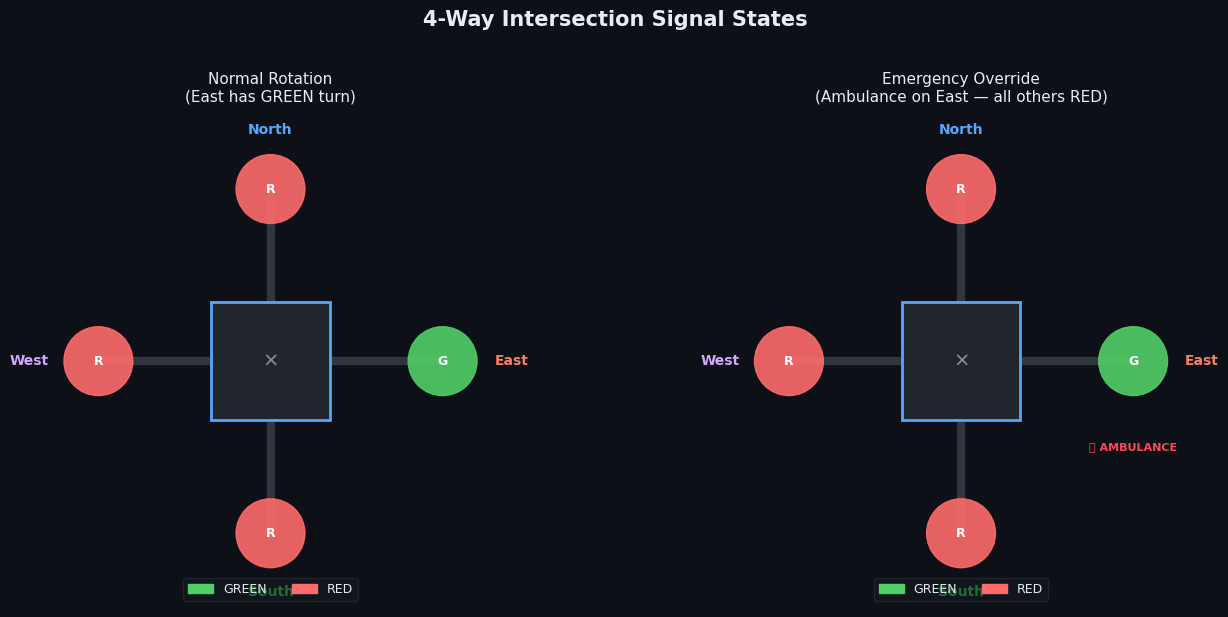

Plot 1 — Intersection diagram saved.


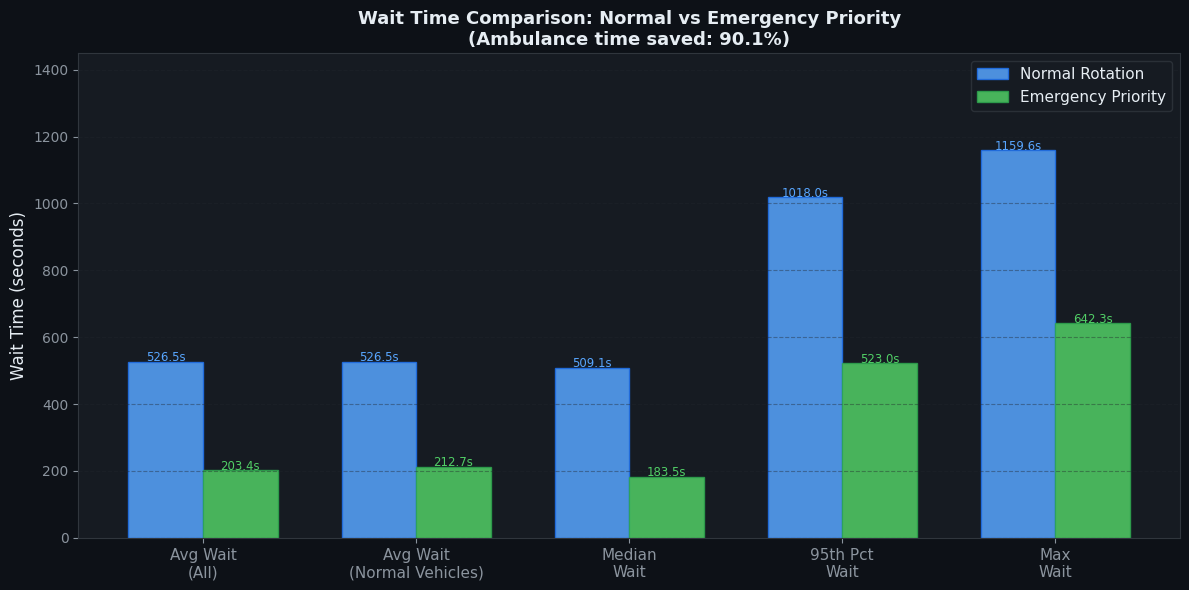

Plot 2 — Wait time comparison saved.


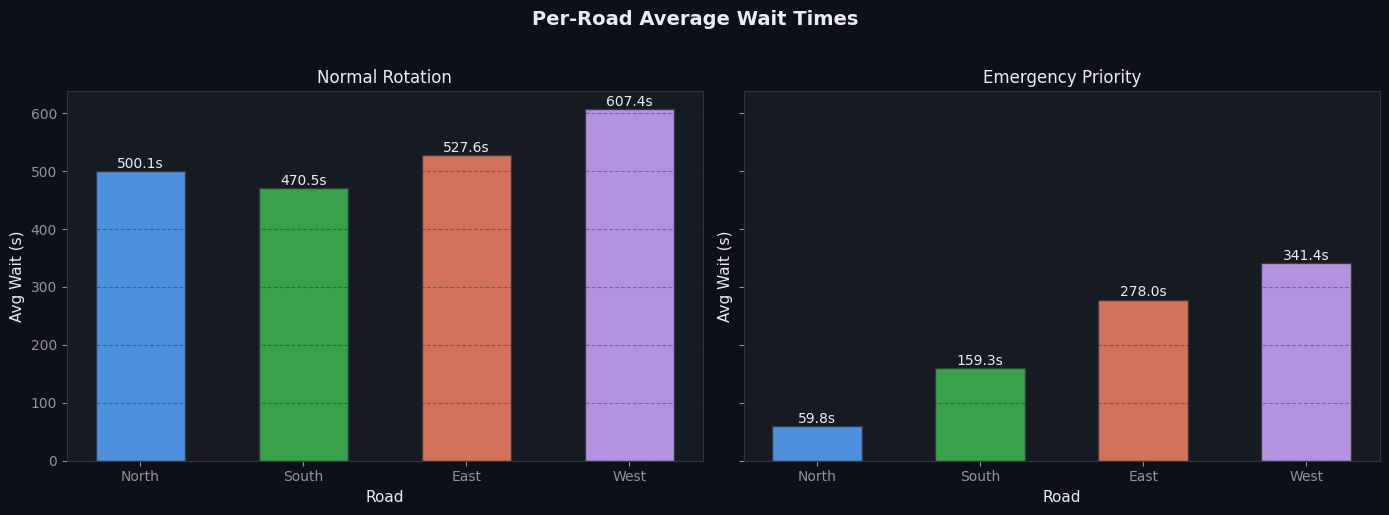

Plot 3 — Per-road breakdown saved.


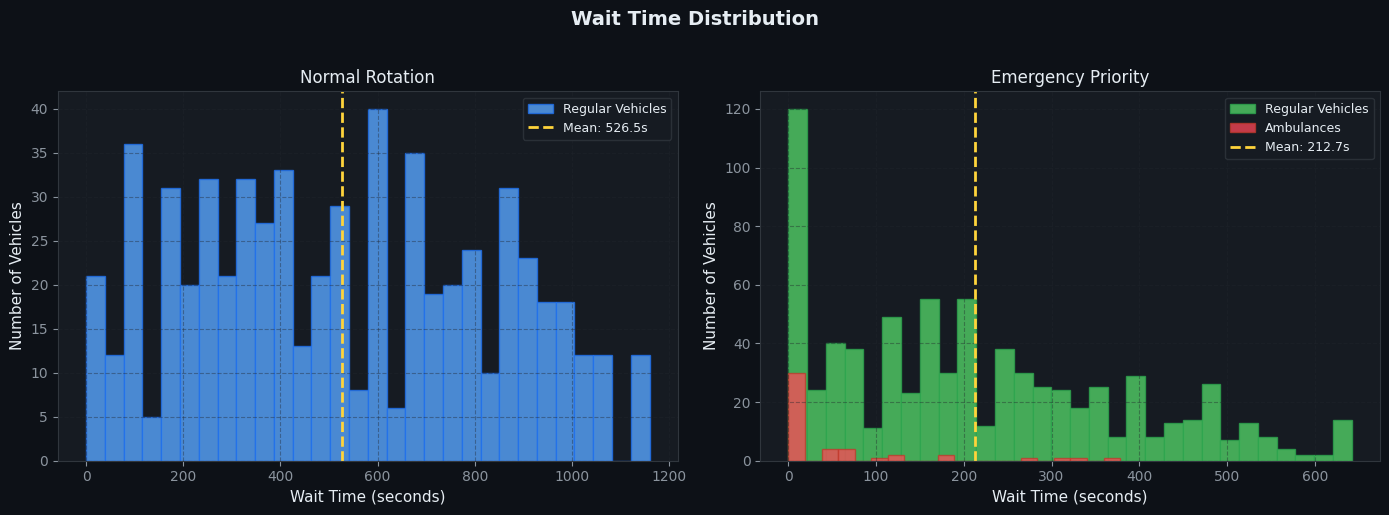

Plot 4 — Wait time distributions saved.


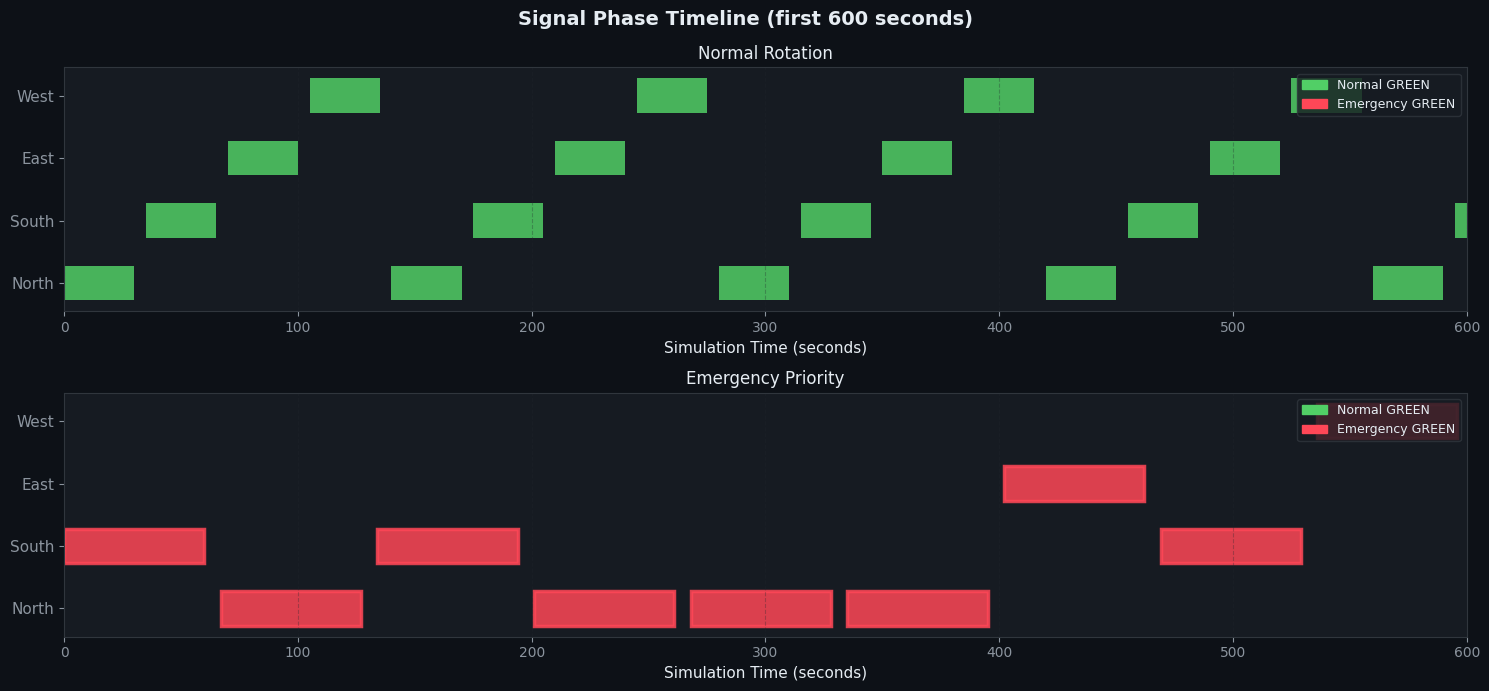

Plot 5 — Phase timeline saved.


/tmp/ipython-input-628797309.py:223: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) DejaVu Sans.
  plt.savefig('plot6_dashboard.png', dpi=140, bbox_inches='tight',
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128678 (\N{VERTICAL TRAFFIC LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


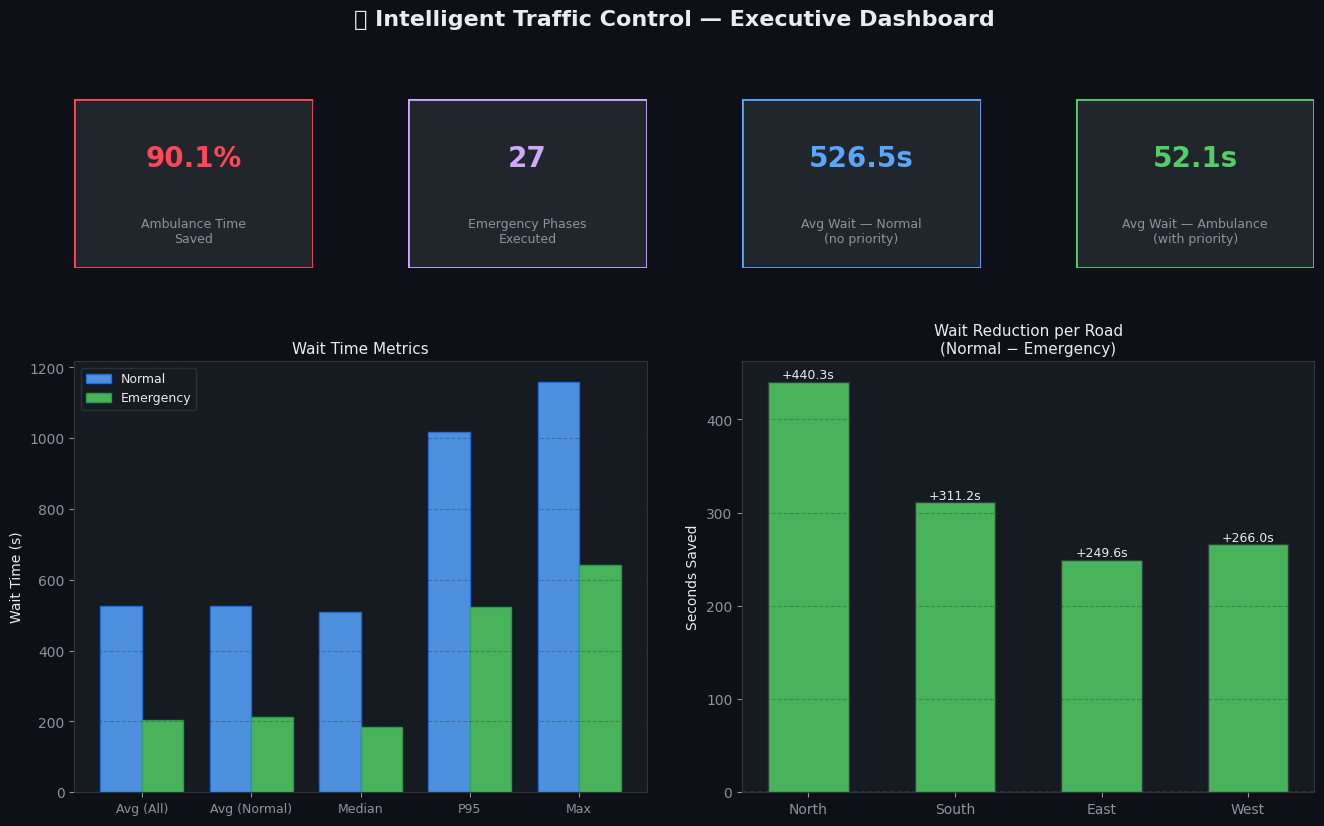

Plot 6 — Executive dashboard saved.

All core plots generated successfully.


In [ ]:
# CELL 10 — Generate All 6 Core Plots

print('Generating visualisations...\n')

# Plot 1: Intersection schematic (normal vs emergency states)
plot_intersection_diagram(normal_result, emergency_result)

# Plot 2: Bar chart — wait time metrics side by side
plot_wait_time_comparison(m_n, m_e, pct_saved)

# Plot 3: Per-road breakdown for both scenarios
plot_per_road_breakdown(m_n, m_e)

# Plot 4: Histogram of wait time distributions
plot_wait_time_distribution(normal_result, emergency_result)

# Plot 5: Gantt-style phase timeline (first 600 seconds)
plot_phase_timeline(normal_result, emergency_result)

# Plot 6: Executive summary dashboard
plot_summary_dashboard(m_n, m_e, pct_saved, normal_result, emergency_result)

print('\nAll core plots generated successfully.')


In [ ]:
# CELL 11 — Inspect the Phase Log
# Shows first 20 phases and a per-road emergency breakdown.

print('='*60)
print('  PHASE LOG — EMERGENCY SCENARIO (first 20 phases)')
print('='*60)

phase_df = emergency_result['phase_log'].head(20).copy()
phase_df['type'] = phase_df['is_emergency'].map(
    {True:'EMERGENCY', False:'Normal'}
)
phase_df['start_time'] = phase_df['start_time'].round(1)
phase_df['end_time']   = phase_df['end_time'].round(1)

print(phase_df[['phase_id','type','active_road','start_time',
                 'end_time','green_duration','vehicles_cleared']].to_string(index=False))

print()
print('Emergency overrides per road:')
full_log = emergency_result['phase_log']
emerg_by_road = full_log[full_log['is_emergency']].groupby('active_road').size()
print(emerg_by_road.to_string())


  PHASE LOG — EMERGENCY SCENARIO (first 20 phases)
 phase_id      type active_road  start_time  end_time  green_duration  vehicles_cleared
        1 EMERGENCY       South         0.0      67.0              60                19
        2 EMERGENCY       North        67.0     134.0              60                19
        3 EMERGENCY       South       134.0     201.0              60                16
        4 EMERGENCY       North       201.0     268.0              60                19
        5 EMERGENCY       North       268.0     335.0              60                 6
        6 EMERGENCY       North       335.0     402.0              60                 5
        7 EMERGENCY        East       402.0     469.0              60                59
        8 EMERGENCY       South       469.0     536.0              60                37
        9 EMERGENCY        West       536.0     603.0              60                73
       10    Normal       North       603.0     638.0              30

Running sensitivity analysis over ambulance probabilities...
  prob=0.01 | avg_amb_wait=4.3s | saved=99.2%
  prob=0.02 | avg_amb_wait=4.4s | saved=99.2%
  prob=0.05 | avg_amb_wait=82.0s | saved=84.4%
  prob=0.08 | avg_amb_wait=66.9s | saved=87.3%
  prob=0.10 | avg_amb_wait=134.0s | saved=74.6%
  prob=0.15 | avg_amb_wait=206.1s | saved=60.9%
  prob=0.20 | avg_amb_wait=118.9s | saved=77.4%


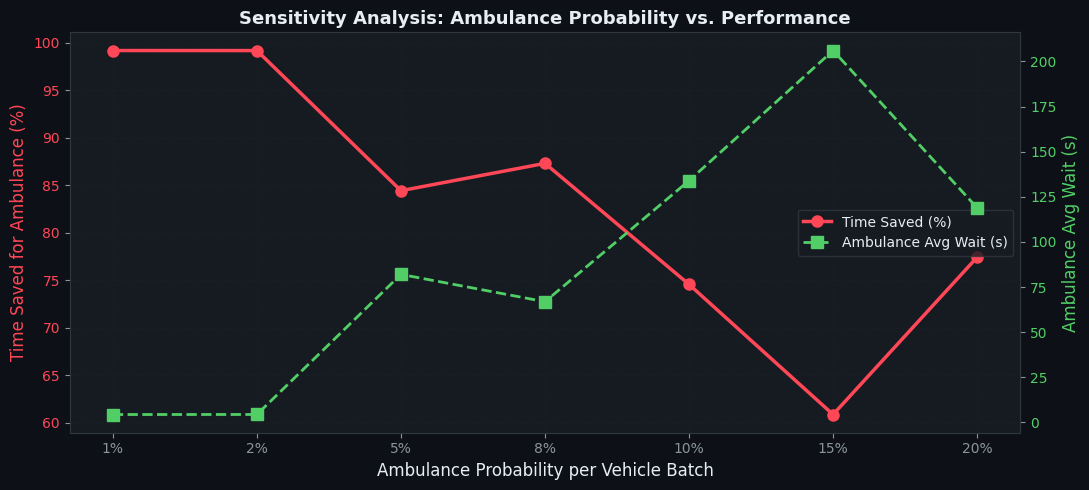

Plot 7 — Sensitivity analysis saved.


In [ ]:
# CELL 12 — Sensitivity Analysis
# Sweeps ambulance probability from 1% to 20%.

print('Running sensitivity analysis over ambulance probabilities...')

amb_probs   = [0.01, 0.02, 0.05, 0.08, 0.10, 0.15, 0.20]
savings_pct = []
amb_waits   = []
norm_wait   = compute_metrics(normal_result)['avg_wait_all']

for prob in amb_probs:
    res = run_simulation(
        scenario='emergency', duration=SIM_DURATION,
        amb_prob=prob, verbose=False
    )
    m = compute_metrics(res)
    avg_amb = m['avg_wait_ambulance'] if m['avg_wait_ambulance'] > 0 else norm_wait
    saved = (norm_wait - avg_amb) / norm_wait * 100
    savings_pct.append(saved)
    amb_waits.append(avg_amb)
    print(f'  prob={prob:.2f} | avg_amb_wait={avg_amb:.1f}s | saved={saved:.1f}%')

# Plot sensitivity results
plot_sensitivity(amb_probs, savings_pct, amb_waits)


In [ ]:
# CELL 13 — Final Printed Summary Report

def print_final_report(m_n, m_e, pct_saved):
    """Print a concise, formatted final report."""
    total_amb     = m_e['total_ambulances']
    total_saved_s = (m_n['avg_wait_all'] - m_e['avg_wait_ambulance']) * total_amb

    border = '=' * 58
    print()
    print(f'+{border}+')
    print(f'|   INTELLIGENT TRAFFIC CONTROL — FINAL REPORT          |')
    print(f'+{border}+')
    print(f'|  Simulation   : {SIM_DURATION}s ({SIM_DURATION//60} minutes)'.ljust(59) + '|')
    print(f'|  Roads        : {", ".join(ROADS)}'.ljust(59) + '|')
    print(f'|  Normal green : {NORMAL_GREEN_TIME}s / Ambulance green: {AMBULANCE_GREEN_TIME}s'.ljust(59) + '|')
    print(f'+{border}+')
    print(f'|  NORMAL SCENARIO'.ljust(59) + '|')
    print(f'|    Avg wait (all vehicles)  : {m_n["avg_wait_all"]:.1f}s'.ljust(59) + '|')
    print(f'|    Throughput               : {m_n["throughput_per_min"]:.1f} veh/min'.ljust(59) + '|')
    print(f'+{border}+')
    print(f'|  EMERGENCY PRIORITY SCENARIO'.ljust(59) + '|')
    print(f'|    Avg wait (all vehicles)  : {m_e["avg_wait_all"]:.1f}s'.ljust(59) + '|')
    print(f'|    Avg wait (ambulance)     : {m_e["avg_wait_ambulance"]:.1f}s'.ljust(59) + '|')
    print(f'|    Emergency overrides      : {m_e["emergency_phases"]}'.ljust(59) + '|')
    print(f'|    Ambulances served        : {total_amb}'.ljust(59) + '|')
    print(f'+{border}+')
    print(f'|  IMPACT SUMMARY'.ljust(59) + '|')
    print(f'|    Ambulance time saved     : {pct_saved:.1f}%'.ljust(59) + '|')
    print(f'|    Total seconds saved      : {total_saved_s:.0f}s across all ambulances'.ljust(59) + '|')
    print(f'+{border}+')
    print()
    print('  Interpretation:')
    print(f'    A {pct_saved:.1f}% reduction in ambulance waiting time means emergency')
    print(f'    vehicles reach their destination significantly faster, which can')
    print(f'    be life-saving in cardiac, stroke, or major trauma emergencies.')
    print(f'    This rule-based system requires NO machine learning and can be')
    print(f'    deployed on existing traffic controllers with simple sensor upgrades.')
    print()


print_final_report(m_n, m_e, pct_saved)



+==========================================================+
|   INTELLIGENT TRAFFIC CONTROL — FINAL REPORT          |
+==========================================================+
|  Simulation   : 1800s (30 minutes)                       |
|  Roads        : North, South, East, West                 |
|  Normal green : 30s / Ambulance green: 60s               |
+==========================================================+
|  NORMAL SCENARIO                                         |
|    Avg wait (all vehicles)  : 526.5s                     |
|    Throughput               : 20.5 veh/min               |
+==========================================================+
|  EMERGENCY PRIORITY SCENARIO                             |
|    Avg wait (all vehicles)  : 203.4s                     |
|    Avg wait (ambulance)     : 52.1s                      |
|    Emergency overrides      : 27                         |
|    Ambulances served        : 47                         |
+=========================